# CO2 emissions factors

This script first recalcualtes the EEA emissions factors 

# Script setup

In [1]:
import os
import logging

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from IPython.display import Image 

#helpers
def get_country(string):
    string = string.split(',')[-1]
    return string

def aligndata(data, CO2_cleaned):
    #CO2_cleaned = CO2[pd.Series(CO2.columns)[pd.Series(CO2.columns).apply(lambda x: x in data.columns)]]
    #consider only countries which appear in both datasets; to have all of them included specific effort is needed.
    data = data[pd.Series(CO2_cleaned.columns)[pd.Series(CO2_cleaned.columns).apply(lambda x: x in data.columns)]].sort_index()
    #data = data.drop(index = '2018 ')
    data = data.set_index(CO2_cleaned.index)
    return data#, CO2_cleaned

# Data directory preparention

In [2]:
# Create input, processed and output folders if they don't exist
# If the paths are relative, the correspoding folders will be created inside the current working directory.

input_directory_path = os.path.join('input')
EEA_methode_input_directory_path = os.path.join('input', 'EEA_Methode')
processed_directory_path = 'processed'
output_directory_path = os.path.join('output')

os.makedirs(input_directory_path, exist_ok=True)
os.makedirs(EEA_methode_input_directory_path, exist_ok=True)
os.makedirs(processed_directory_path, exist_ok=True)
os.makedirs(output_directory_path, exist_ok=True)

# Data file preperation

The directory `input/EEA_Methode` should contain all necessary raw data files.

Eurostat energy balance database
https://ec.europa.eu/eurostat/web/energy/data/database
Complete energy balances as ZIP archive -> nrg_bal_c.tsv (tab separated file)
https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/nrg_bal_c.tsv.gz

National emissions reported to the UNFCCC and to the EU Greenhouse Gas Monitoring Mechanism
https://www.eea.europa.eu/data-and-maps/data/national-emissions-reported-to-the-unfccc-and-to-the-eu-greenhouse-gas-monitoring-mechanism-16
Reported emissions as ZIP archive -> UNFCCC_v23.csv (ASCII delimited)
https://www.eea.europa.eu/data-and-maps/data/national-emissions-reported-to-the-unfccc-and-to-the-eu-greenhouse-gas-monitoring-mechanism-16/national-greenhouse-gas-inventories-ipcc-common-reporting-format-sector-classification/ascii-delimited-zip-2/at_download/file



In [3]:
# Checks if the the input directories are empty or not
# Checks all filenames in the input directory

if not os.listdir(EEA_methode_input_directory_path) :
    print("The directory for the EEA methode is empty. Please provide the data to the directory as described in the instructions above.")


EEA_filenames = [os.path.join(EEA_methode_input_directory_path, fn) for fn in os.listdir(EEA_methode_input_directory_path)]

print(EEA_filenames)

['input\\EEA_Methode\\EEA_methodology.png', 'input\\EEA_Methode\\nrg_bal_c.csv', 'input\\EEA_Methode\\UNFCCC_v23.csv']


# Load data functions

In [4]:
# load and clean TP data function

def load_energy_balance_data(path, fn):
    """
    Load and standardize the raw energy balances reported in the eurostat database for all european countriesenergy from input directory.
    Filter data, see documentation from EEA
    
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename

    """
    

    logging.info(f'Loading data from {fn}')
    
    df = pd.read_csv(os.path.join(path, fn),sep = '\t', header=0)
    # rename column (0) for identifier
    df = df.rename(columns = {df.columns[0]:'use_substance_unit_country'})

    return df


def load_UNFCC_data(path, fn):
    """
    Load and standardize the raw UNFCC database for all european countriesenergy from input directory.
    Filter data: only sector '1.A.1.a' (CO2 for all energy production from Public Electricity Generation, Public Combined Heat and Power and Public Heat Plants)
    Filter data: only direct CO2 emissions
    Filter data: only from year 1990 upwards
    CO2 emmissions in million tones Tg

    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename

    """
    

    logging.info(f'Loading data from {fn}')
    
    df = pd.read_csv(os.path.join(path, fn), sep = ',', header =0, encoding = 'unicode_escape',low_memory=False)
    
    #sector and polutant selection
    sector = '1.A.1.a' # CO2 for all energy production from Public Electricity Generation, Public Combined Heat and Power and Public Heat Plants
    pollutant = 'CO2' # only direct CO2
    
    df = df.query('Sector_code == @sector').query('Pollutant_name == @pollutant')
    
    # data only from year 1990 upwards 
    df = df[~df['Year'].isin(['1985-1987'])] # skip an entry with several years
    # convert all years to string
    df['Year']= df['Year'].apply(lambda x: int(x)).apply(lambda x: str(x))
    
    df = df[~df['Year'].isin(['1985','1986','1987','1988','1989'])] # filter for years
    
    # Create table with countries as columns and years as rows 
    df = pd.pivot_table(df, values = 'emissions', index = 'Year', columns = ['Country_code'])

    return df

# Methodology

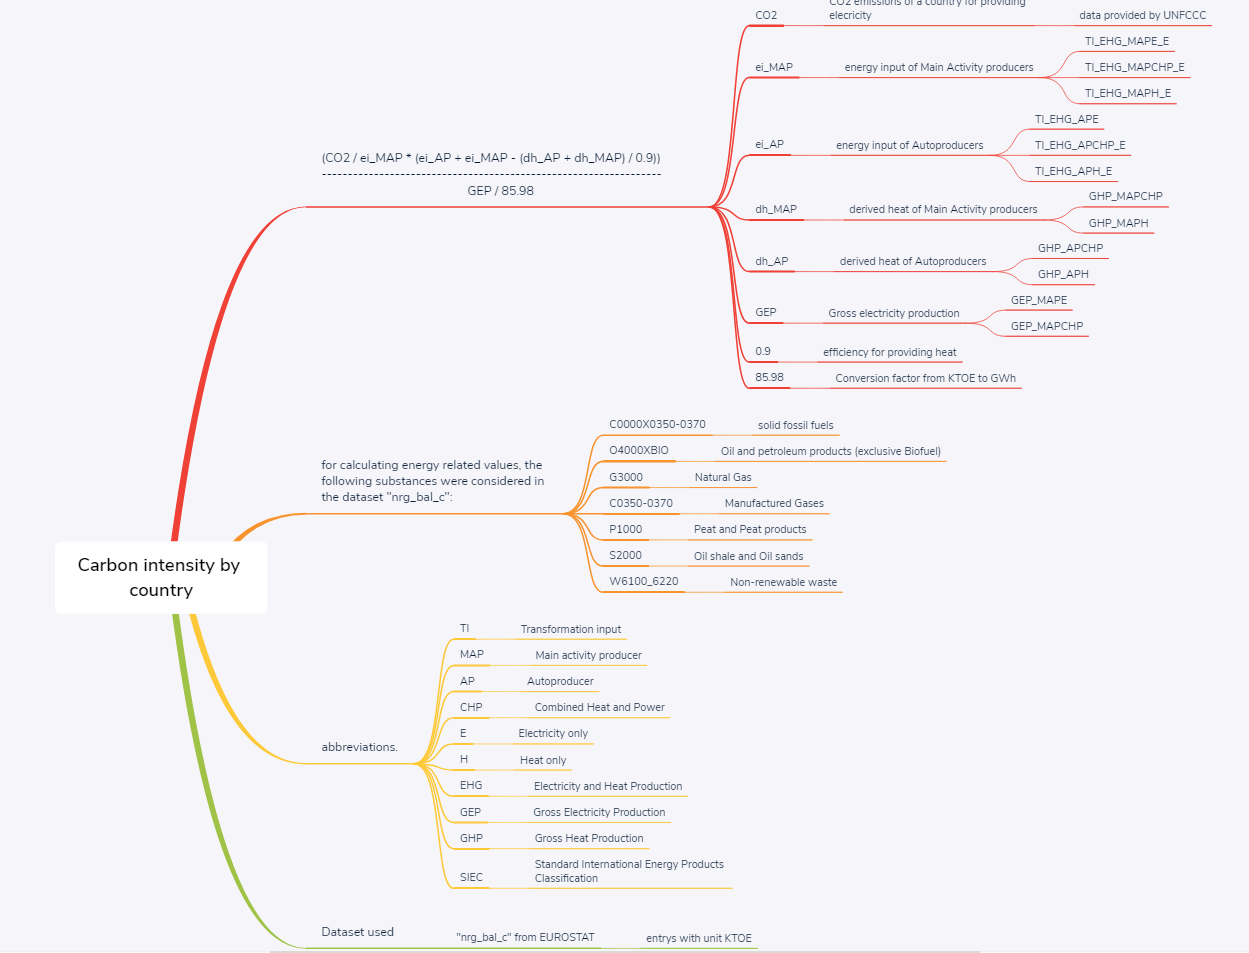

In [5]:
# The following image give information about the used data sets, abbrevations and calculation mathode
Image(filename="Input/EEA_Methode/EEA_methodology.png")

## load CO2_emissions reported from UNFCC

In [6]:
CO2_emissions_UNFCC = load_UNFCC_data(EEA_methode_input_directory_path, 'UNFCCC_v23.csv')

## load energy balance sheet reported from eurostat

In [7]:
nrg_bal_c = load_energy_balance_data(EEA_methode_input_directory_path, 'nrg_bal_c.csv')

## energy related calculations

caculation for ei_MAP, ei_AP, dh_MAP, dh_AP, GEP
see image for further information

In [11]:
#energy input of main activity producers (ei_MAP)

#using only substances provided in the example excel-sheet (Austria Example). Nevertheless, the methodology on the website
#suggests using two more substances namely biogases and primary solid biofuels
ei_MAP_string_nrgbalc = 'TI_EHG_MAPE_E|TI_EHG_MAPCHP_E|TI_EHG_MAPH_E'
substances = 'C0000X0350-0370|O4000XBIO|G3000|C0350-0370|P1000|S2000|W6100_6220'

#filter with ei_MAP_string_nrgbalc and substances
ei_MAP = nrg_bal_c.loc[nrg_bal_c['use_substance_unit_country']\
                                    .str.contains(ei_MAP_string_nrgbalc, regex=True)]
ei_MAP = ei_MAP.loc[ei_MAP['use_substance_unit_country']\
                                     .str.contains(substances, regex=True)]
ei_MAP = ei_MAP.loc[ei_MAP['use_substance_unit_country']\
                                    .str.contains(r'^(?=.*KTOE)')]
# split country from identifier
ei_MAP.use_substance_unit_country = ei_MAP.use_substance_unit_country.apply(lambda string: get_country(string))
# rename columns and set index
ei_MAP = ei_MAP.rename(columns = {'use_substance_unit_country':'Country_code'})\
           .set_index('Country_code')\
           .replace(': ',0.)\
           .replace(': z',0.)\
           .apply(lambda x: x.apply(lambda y:float(y)))\
           .groupby(by=ei_MAP.index.name,level = 0).sum()\
           .T

In [12]:
#calculating the derived heat of main activity producers(dh_MAP)

#filter
derived_heat_string_nrgbalc = 'GHP_MAPCHP|GHP_MAPH'

dh_MAP = nrg_bal_c.loc[nrg_bal_c['use_substance_unit_country']\
                                     .str.contains(derived_heat_string_nrgbalc, regex=True)]
dh_MAP = dh_MAP.loc[dh_MAP['use_substance_unit_country']\
                                        .str.contains(substances, regex=True)]
dh_MAP = dh_MAP.loc[dh_MAP['use_substance_unit_country']\
                                      .str.contains(r'^(?=.*KTOE)')]
dh_MAP.use_substance_unit_country = dh_MAP.use_substance_unit_country\
                                     .apply(lambda string: get_country(string))
dh_MAP = dh_MAP.rename(columns = {'use_substance_unit_country':'Country_code'})\
           .set_index('Country_code')\
           .replace(': ',0.)\
           .replace(': z',0.)\
           .apply(lambda x: x.apply(lambda y:float(y)))\
           .groupby(by=dh_MAP.index.name,level = 0).sum()\
           .T\
           #/ 0.9 # Estimating 90% efficiency heat production

In [13]:
#calculating the energy input of Autoproducters (ei_AP)
AP_string = 'TI_EHG_APE_E|TI_EHG_APCHP_E|TI_EHG_APH_E'
ei_AP = nrg_bal_c.loc[nrg_bal_c['use_substance_unit_country'].str.contains(AP_string, regex=True)]

ei_AP = ei_AP.loc[ei_AP['use_substance_unit_country']\
                                                    .str.contains(substances,regex=True)]#
ei_AP = ei_AP.loc[ei_AP['use_substance_unit_country']\
                                      .str.contains(r'^(?=.*KTOE)')]
ei_AP.use_substance_unit_country = ei_AP.use_substance_unit_country\
                                                    .apply(lambda string: get_country(string))
ei_AP = ei_AP.rename(columns = {'use_substance_unit_country':'Country_code'})\
           .set_index('Country_code')\
           .replace(': ',0.)\
           .replace(': z',0.)\
           .apply(lambda x: x.apply(lambda y:float(y)))\
           .groupby(by=ei_AP.index.name,level = 0).sum()\
            .T


In [14]:
#calculating the derived heat of Autoproducters (dh_AP)
dh_AP_string = 'GHP_APCHP|GHP_APH'
dh_AP = nrg_bal_c.loc[nrg_bal_c['use_substance_unit_country']\
                                     .str.contains(dh_AP_string, regex=True)]
dh_AP = dh_AP.loc[dh_AP['use_substance_unit_country']\
                                        .str.contains(substances, regex=True)]
dh_AP = dh_AP.loc[dh_AP['use_substance_unit_country']\
                                      .str.contains(r'^(?=.*KTOE)')]
dh_AP.use_substance_unit_country = dh_AP.use_substance_unit_country\
                                     .apply(lambda string: get_country(string))
dh_AP = dh_AP.rename(columns = {'use_substance_unit_country':'Country_code'})\
           .set_index('Country_code')\
           .replace(': ',0.)\
           .replace(': z',0.)\
           .apply(lambda x: x.apply(lambda y:float(y)))\
           .groupby(by=dh_AP.index.name,level = 0).sum()\
           .T\
           #/ 0.9 # Estimating 90% efficiency heat production


In [15]:
#caclulating gross electricty prodcution of main activity producers (GEP)
MAP_string = 'GEP_MAPE|GEP_MAPCHP'

GEP_MAP = nrg_bal_c.loc[nrg_bal_c['use_substance_unit_country'].str.contains(MAP_string, regex=True)]

GEP_MAP = GEP_MAP.loc[GEP_MAP['use_substance_unit_country']\
                                                      .str.contains(r'^(?=.*KTOE)(?=.*TOTAL)')]
GEP_MAP.use_substance_unit_country = GEP_MAP.use_substance_unit_country\
                                                      .apply(lambda string: get_country(string))
GEP_MAP = GEP_MAP.rename(columns = {'use_substance_unit_country':'Country_code'})\
           .set_index('Country_code')\
           .replace(': ',0.)\
           .replace(': z',0.)\
           .apply(lambda x: x.apply(lambda y:float(y)))\
           .groupby(by=GEP_MAP.index.name,level = 0).sum()\
           .T


In [16]:
#aclulating gross electricty prodcution of Autoproductersof (GEP_AP)
AP_string = 'GEP_APE|GEP_APCHP'

GEP_AP = nrg_bal_c.loc[nrg_bal_c['use_substance_unit_country'].str.contains(AP_string, regex=True)]

GEP_AP = GEP_AP.loc[GEP_AP['use_substance_unit_country']\
                                                    .str.contains(r'^(?=.*KTOE)(?=.*TOTAL)')]
GEP_AP.use_substance_unit_country = GEP_AP.use_substance_unit_country\
                                                    .apply(lambda string: get_country(string))
GEP_AP = GEP_AP.rename(columns = {'use_substance_unit_country':'Country_code'})\
           .set_index('Country_code')\
           .replace(': ',0.)\
           .replace(': z',0.)\
           .apply(lambda x: x.apply(lambda y:float(y)))\
           .groupby(by=GEP_AP.index.name,level = 0).sum()\
           .T


In [20]:
#filter CO2_emissions_UNFCC using only columns that exist in both dataframes
CO2_cleaned = CO2_emissions_UNFCC[pd.Series(CO2_emissions_UNFCC.columns)[pd.Series(CO2_emissions_UNFCC.columns).apply(lambda x: x in ei_MAP.columns)]]

Country_code,AT,BE,BG,CY,CZ,DE,DK,EE,ES,FI,...,IT,LT,LU,LV,MT,NL,NO,PL,PT,UK
Year,,,,,,,,,,,,,,,,,,,,,
1990,11079.37937,23536.55477,35178.68512,1675.7700,54584.89821,338451.15956,24697.30400,29026.60444,65575.40975,16453.36654,...,108527.20957,12002.94991,33.28747,6082.62322,1758.51510,40027.04563,407.67909,227279.46095,14354.84069,203115.85003
1991,11792.00983,24362.08290,28740.82018,1738.0500,53639.82372,330998.85463,33469.44763,26523.51980,66285.13489,16214.45090,...,103947.54505,12856.57251,34.82810,5598.42101,1599.05046,40510.47376,448.17275,223117.49086,15193.29929,199721.53375
1992,8601.63357,23126.54671,27729.86174,2031.6700,52865.50354,318273.92534,28319.94896,20027.69866,73945.38977,15976.33345,...,103726.81981,7587.97382,34.72748,4735.59077,1536.25498,41030.77912,432.49158,214502.32398,18112.04344,187719.12068
1993,8436.11870,23327.59874,27767.04672,2165.2700,52744.49926,309409.00613,29865.09104,15703.93474,68124.86809,18742.21008,...,98354.41785,5944.34965,33.03727,3839.22222,2101.82796,42415.09179,448.13574,199847.00546,16097.52835,170385.13074
1994,8712.95608,24400.56723,25501.35336,2258.6900,53233.35748,310108.82988,33769.49811,15929.85572,66898.58299,23298.64972,...,100660.79151,6289.88405,32.32314,3606.18284,1809.12180,46234.37000,494.09731,194329.77624,14762.84545,166212.71414
1995,9869.38161,24182.38791,25832.77783,2075.9200,57727.02219,304600.12251,30051.44639,14387.55628,72727.45721,21050.87054,...,110191.37888,5596.36266,91.29444,3260.09414,1590.47368,48507.41206,494.08491,177729.32229,17361.53786,163159.19830
1996,11090.02464,23004.05663,25700.27480,2196.8700,60667.16817,317599.59117,42196.89379,14912.85678,59511.65275,26529.12206,...,105159.16841,6126.29003,80.60930,3324.80609,1646.97654,49190.88304,582.76576,184150.32870,13444.33756,162836.60761
1997,11108.58837,22190.08988,28174.73969,2321.5500,56757.39183,303918.51243,33109.17456,14475.67438,71582.83822,24385.26258,...,102065.40039,5429.39352,87.66548,3190.44165,1611.63054,49615.93665,528.60524,178796.41534,14089.61580,150330.59012
1998,10107.57024,24859.99414,27153.08062,2550.6900,54374.49731,309575.40102,29470.66356,12960.68825,71294.90583,20952.89486,...,102870.46793,6013.76378,153.38816,3086.90784,1636.40886,51467.00054,563.20066,172344.61348,16531.65288,155430.95652


In [22]:
# fit data to CO2_cleaned data columns and rows
ei_MAP = aligndata(ei_MAP,CO2_cleaned)

dh_MAP= aligndata(dh_MAP, CO2_cleaned)
#refers to second part of field D13 in example excelsheet.
#(energy_input_nrgbalc-dh_MAP)/85.9845

ei_AP = aligndata(ei_AP, CO2_cleaned)

dh_AP = aligndata(dh_AP, CO2_cleaned)

GEP_MAP= aligndata(GEP_MAP, CO2_cleaned) 

GEP_AP = aligndata(GEP_AP, CO2_cleaned )

GEP = GEP_AP + GEP_MAP



In [25]:
CI_calc = (CO2_cleaned/ei_MAP*(ei_AP + ei_MAP - (dh_AP + dh_MAP)/0.9))\
                /(GEP/85.98)#85.98: Ktoe-->GWh

In [26]:
CI_calc

Country_code,AT,BE,BG,CY,CZ,DE,DK,EE,ES,FI,...,IT,LT,LU,LV,MT,NL,NO,PL,PT,UK
Year,,,,,,,,,,,,,,,,,,,,,
1990,238.358989,357.415955,594.799812,848.878560,776.724191,658.634413,676.782276,1001.303713,446.504069,187.203649,...,559.354723,199.192900,399.949503,344.185900,1598.565580,610.103074,1.126608,1474.886073,517.867475,676.825331
1991,247.951319,363.532817,557.369755,836.763195,772.174853,662.401805,691.286623,1010.251227,441.566064,171.622834,...,533.268785,201.799273,429.061601,295.447300,1126.826530,586.521560,1.335528,1446.530548,524.508989,663.475217
1992,192.669058,347.512135,683.768810,836.035774,770.918007,634.481490,662.637342,1051.642716,482.713918,154.730910,...,522.759732,128.680786,489.928981,317.688952,1030.988887,576.320693,0.750602,1427.217185,619.141403,633.935550
1993,175.949759,357.461595,658.897132,835.967286,768.881996,626.128707,627.748174,1050.403362,454.906453,189.295780,...,515.427979,107.298681,536.274526,242.125588,1401.142591,576.159273,0.856562,1244.535847,542.005273,573.418250
1994,194.279105,364.795385,601.092176,841.182694,769.056403,621.505211,628.702668,1146.217046,447.026957,248.863626,...,509.670966,135.745631,406.720247,179.663660,1173.931657,589.112837,1.714094,1194.768053,504.302827,545.475426
1995,203.120026,350.386214,553.220734,831.323277,778.702623,600.250453,596.539006,1271.296585,492.769193,222.093732,...,538.766754,82.532404,930.893965,170.857670,974.501892,568.608605,1.774469,1033.750531,571.211553,528.824946
1996,211.306535,322.720148,526.693813,841.989545,776.834848,585.309068,624.141827,1254.020171,385.292510,275.322051,...,518.541891,98.197829,907.746436,224.289268,993.301461,540.331695,2.302659,1023.413492,434.516062,515.623886
1997,209.909637,293.666959,549.719380,850.962497,730.748840,569.575945,575.620728,1201.432810,424.589413,246.416560,...,509.636250,92.709340,481.437763,151.186984,955.839097,539.370946,1.726207,1002.203963,464.528633,484.832475
1998,183.290986,311.594663,564.769181,852.742539,721.070909,569.690830,536.054348,1200.936951,421.811419,200.110972,...,509.796482,118.192286,338.124777,103.542864,950.800004,520.903705,1.743572,970.949648,472.479496,482.357078


In [34]:
CI_calc.to_csv(output_directory_path + '/CI_EEA_recalculated.csv')